# E11. Medical Image Classification

흉부 X-RAY 이미지를 통해 폐렴을 탐지하는 모델을 만들어보자.

* 폐렴환자의 흉부 X-RAY 사진 : 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰된다.
* 정상상태의 흉부 X-RAY 사진 : 비정상적인 음영 영역이 없는 깨끗한 폐가 관찰된다.

## 1. 라이브러리 및 패키지 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 2. 데이터 준비하기

### 데이터 가져오기

In [2]:
# 데이터 로드할 떄 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # tf.io.gfile.glob : 주어진 패턴과 일치하는 파일 목록 반환
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* Validation Data의 개수가 너무 부족하기 때문에 Train과 Val의 데이터를 합쳐 8:2 비율로 다시 나눈다.

In [3]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH)) # 리스트 끝에 x(리스트이든, 딕셔너리든 그대로)를 그대로 넣는 append에 비해 리스트 끝에 iterable의 모든 항목을 넣는다.

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8) # math.floor : x보다 작거나 같은 가장 큰 정수인 x의 바닥값(floor)를 반환한다. 80%에 해당하는 floor값 반환
random.seed(7)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0687-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0410-0001.jpeg


In [5]:
# 파일 경로의 NORMAL개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로의 PNEUMONIA개수 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1074
Pneumonia images count in training set: 3111


### Train Dataset 만들기

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"    # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_dataset = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_dataset.take(1):
    print("Image shape : ", image.numpy().shape)
    print("Label : ", label.numpy())

Image shape :  (180, 180, 3)
Label :  False


### Test Dataset 만들기

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 무작위로 섞기
    ds = ds.repeat()                                 
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_dataset)
val_ds = prepare_for_training(val_dataset)

train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

### 데이터 시각화

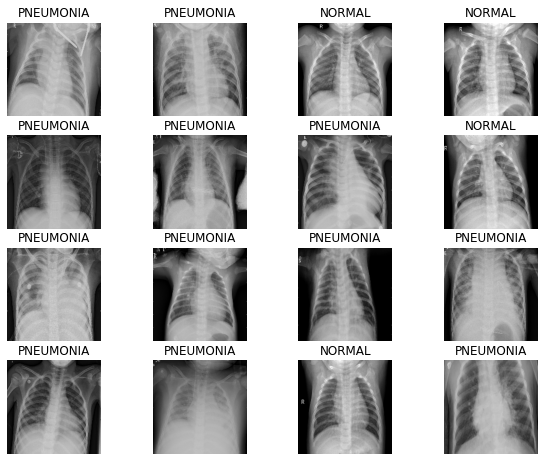

In [14]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여준다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 3. CNN 모델 설계 및 학습

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Data Imbalance 해결

In [17]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print('Weight for NORMAL : {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA : {:.2f}'.format(weight_for_1))

Weight for NORMAL : 1.95
Weight for PNEUMONIA : 0.67


### 학습

In [18]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 142ms/step - loss: 0.5066 - accuracy: 0.7232 - precision: 0.9331 - recall: 0.6763 - val_loss: 0.6426 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2519 - accuracy: 0.8943 - precision: 0.9752 - recall: 0.8807 - val_loss: 1.2350 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2066 - accuracy: 0.9284 - precision: 0.9723 - recall: 0.9300 - val_loss: 0.2322 - val_accuracy: 0.9019 - val_precision: 0.8828 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 35s 134ms/step - loss: 0.1897 - accuracy: 0.9237 - precision: 0.9783 - recall: 0.9188 - val_loss: 0.1700 - val_accuracy: 0.9288 - val_precision: 0.9392 - val_recall: 0.9661
Epoch 5/25
261/261 [==============================] - 35s 133ms/step - loss: 0.1623 - accura

### 학습 결과

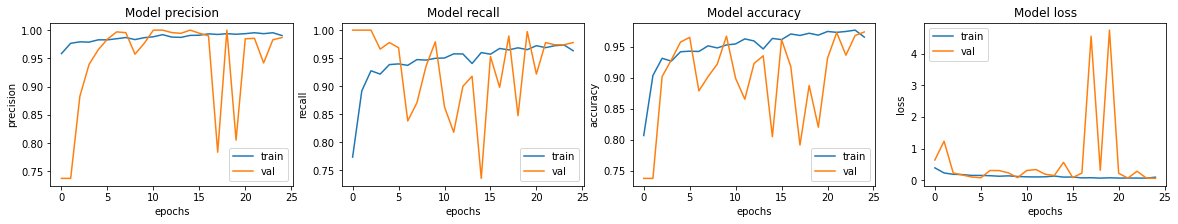

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 평가

In [21]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.9755 - accuracy: 0.7692 - precision: 0.7330 - recall: 0.9923
Loss: 0.9754814505577087, 
Accuracy: 0.7692307829856873, 
Precision: 0.7329545617103577, 
Recall: 0.9923076629638672


## 4. 정확도 향상
1. Hyper Parameters
2. Data Augmentation

### 하이퍼 파라미터 조정을 위한 함수 선언

In [22]:
def attempt(train_ds=train_dataset, val_ds=val_dataset,
            BATCH_SIZE=16, EPOCHS=25, 
            optimizer='adam', loss_fn='binary_crossentropy', 
            weight=True, augmentation=False):
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)

    def augment(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label

    def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        if augmentation:
            ds = ds.map(
                    augment,       # augment 함수 적용
                    num_parallel_calls=2
                )
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)

    with tf.device('/GPU:0'):
        model = build_model()
        
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=METRICS)
            
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            verbose=0)
        
    condition = {
        'batch_size' : BATCH_SIZE,
        'epochs' : EPOCHS,
        'loss_fn' : loss_fn,
        'optimizer' : optimizer,
        'class_weight' : class_weight,
        'augmentation' : augmentation}
    
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}')
    
    eval_result = {
        'loss' : loss,
        'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall}
    
    return history, eval_result, condition

### 하이퍼 파라미터 조정 및 Augmentation 적용 후 학습

In [23]:
history_normal = attempt()                          # 기본값
history_optimizer = attempt(optimizer='sgd')        # Optimizer SGD로 변경
history_batch = attempt(BATCH_SIZE=32)               # Batch size 32로 변경
history_epochs = attempt(EPOCHS=32)                 # epoch 32으로 변경
history_augmentation = attempt(augmentation=True)  # Augmentation 실시

39/39 [==============================] - 3s 74ms/step - loss: 1.5259 - accuracy: 0.7436 - precision: 0.7106 - recall: 0.9949
Loss: 1.525941252708435 | Accuracy: 0.7435897588729858 | Precision: 0.7106227278709412 | Recall: 0.9948717951774597
39/39 [==============================] - 3s 75ms/step - loss: 0.6903 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6903038620948792 | Accuracy: 0.625 | Precision: 0.625 | Recall: 1.0
20/20 [==============================] - 3s 140ms/step - loss: 1.0004 - accuracy: 0.8013 - precision: 0.7628 - recall: 0.9897
Loss: 1.0003596544265747 | Accuracy: 0.8012820482254028 | Precision: 0.7628458738327026 | Recall: 0.9897435903549194
39/39 [==============================] - 3s 72ms/step - loss: 0.8698 - accuracy: 0.8413 - precision: 0.8063 - recall: 0.9821
Loss: 0.8697644472122192 | Accuracy: 0.8413461446762085 | Precision: 0.8063157796859741 | Recall: 0.9820512533187866
39/39 [==============================] - 3s 73ms/step - loss: 0.5144 - ac

### 하이퍼 파라미터 조정 및 Augmentation 적용 후 결과

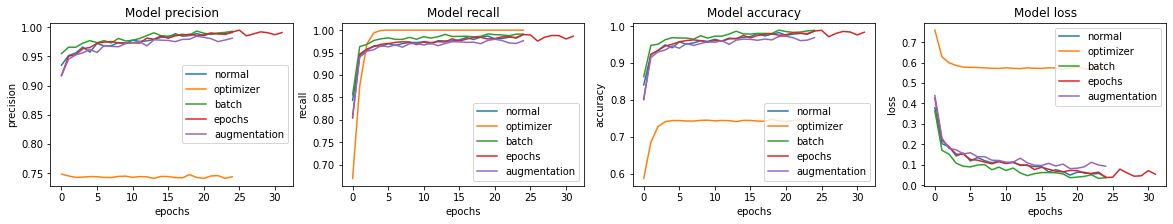

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

history_list = [history_normal, history_optimizer, history_batch, history_epochs, history_augmentation]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for history in history_list:
        ax[i].plot(history[0].history[met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['normal', 'optimizer', 'batch', 'epochs', 'augmentation'])

In [25]:
for history in history_list:
    print(history[1]['accuracy'])

0.7435897588729858
0.625
0.8012820482254028
0.8413461446762085
0.8445512652397156


## 5. 결론
* Optimizer, Batch size, Epochs, Augmentation 등 학습 결과에 영향을 줄 수 있는 하이퍼파라미터 및 전처리를 각각 적용해 보았다.
* 각각 정확도 등을 확인했을 때, Epoch를 32로 설정했을 때와, Augmentation 했을 때 84% 정도의 높은 정확도를 보였다.
* random_seed의 변경 시에도 약간의 정확도 변경을 보였다.
* 정확도 외에 Precision과 Recall 값을 확인했을 때 Recall값이 높게 측정되는 것을 보았을 때, 의료 데이터에 적합한 모델임은 확인할 수 있다.
